##### Authors: Rafael Dousse, Eva Ray, Massimo Stefani

# k-Nearest Neighbor (kNN) exercise 4 - Fashion Dataset

*Complete and hand in this completed worksheet.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- In this exercise, the ultimate goal is to find an optimal value of hyper-parameter k through a cross-validation procedure.

In this exercise you will implement these steps and gain proficiency in writing efficient, vectorized code.

In [97]:
# Install TensorFlow if not already installed
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [98]:
# Run some setup code for this notebook.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window. Also setting some parameters for display.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [99]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.astype(float)
X_test  = X_test.astype(float)
print('Training data shape:', X_train.shape)   # (60000, 28, 28)
print('Training labels shape:', y_train.shape) # (60000,)
print('Test data shape:', X_test.shape)        # (10000, 28, 28)
print('Test labels shape:', y_test.shape)      # (10000,)


Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


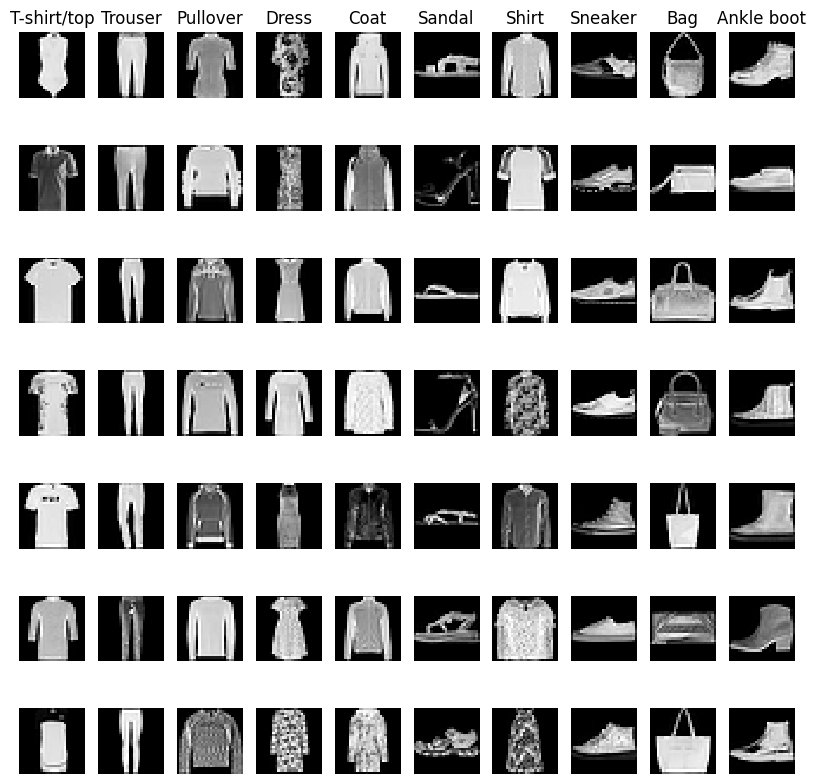

In [100]:
# Now let's visualise some of the images
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1 
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [101]:
# Subsample the data for more efficient code execution in this exercise. We do this to make it go faster. 
# When you will have completed the whole notebook, you can run it again on a larger (or total) dataset 
# and observe the difference in terms of accuracy (and speedup).
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# TODO: sanity check: write code to print out the size of the subsampled training and test data.
print('Subsampled training data shape:', X_train.shape)   # (5000, 28, 28)
print('Subsampled training labels shape:', y_train.shape) # (5000,)
print('Subsampled test data shape:', X_test.shape)        # (500, 28, 28)
print('Subsampled test labels shape:', y_test.shape)      # (500,)

Subsampled training data shape: (5000, 28, 28)
Subsampled training labels shape: (5000,)
Subsampled test data shape: (500, 28, 28)
Subsampled test labels shape: (500,)


**Inline Question #1:** Notice the outputs of the shape attributes for the numpy arrays downloaded.

- What are the ranks of the arrays for the training data and test data?
- Are the shapes coherent from the description of the dataset? Explain the different dimensions of the 4 arrays in cell above.

**Your Answer**: The rank of the image arrays (training and test) is 3, because each image is represented as a 3D array (number of samples × height × width). The labels are 1D vectors, so their rank is 1. So:

- `X_train` and `X_test`: rank 3 (number of samples × height × width)
- `y_train` and `y_test`: rank 1 (number of labels)

The shapes are coherent with the Fashion-MNIST dataset description: 60,000 training images and 10,000 test images, each of size 28×28 pixels representing grayscale images of 10 clothing categories.

In [102]:
# Shape the images vectors
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # when reshaping, -1 means "infer target dims from orig dims
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 784) (500, 784)


**Inline Question #2:** Notice the use of np.reshape to transform images into vectors.

- What is the effect of -1 in the reshape command?
- Are the shapes coherent from this vectorization? Explain.

**Your Answer**: The reshape operation is used to change the dimensions of the data arrays. In this case, the `(X_train.shape[0], -1)` means that we keep the first dimension (number of samples) and let NumPy automatically calculate the size of the second dimension with the `-1`. It is coherent because each image of size 28×28 pixels is flattened into a vector of size 784 (28×28 = 784).

Therefore, the new shape of `X_train` becomes `(5000, 784)` and `X_test` becomes `(500, 784)`, where each row corresponds to a flattened image.

In [103]:
# This is a class definition for our KNN classifier. Complete the code indicated by the TODO sections.
import numpy as np

class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):
            #########################################################################
            # TODO: Compute the l2 distance between the ith test point and the     #
            # jth training point, and store the result in dists[i, j]. You should  #
            # not use a loop over dimension.                                        #
            #########################################################################
            dists[i, j] = np.sqrt(np.sum((X[i, :] - self.X_train[j, :]) ** 2))
            #########################################################################
            #                       END OF YOUR CODE                               #
            #########################################################################
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      #######################################################################
      # TODO:                                                               #
      # Compute the l2 distance between the ith test point and all training #
      # points, and store the result in dists[i, :].                        #
      #######################################################################
      dists[i, :] = np.sqrt(np.sum((self.X_train - X[i])**2, axis=1))
      #######################################################################
      #                         END OF YOUR CODE                            #
      #######################################################################
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    #########################################################################
    # TODO:                                                                 #
    # Compute the l2 distance between all test points and all training      #
    # points without using any explicit loops, and store the result in      #
    # dists.                                                                #
    #                                                                       #
    # You should implement this function using only basic array operations; #
    # in particular you should not use functions from scipy.                #
    #                                                                       #
    # HINT: Try to formulate the l2 distance using matrix multiplication    #
    #       and two broadcast sums.                                         #
    #########################################################################

    # (num_test, 1)
    test_sq = np.sum(X ** 2, axis=1, keepdims=True)
    # (1, num_train)
    train_sq = np.sum(self.X_train ** 2, axis=1).reshape(1, -1)
    # (num_test, num_train)
    cross_term = X.dot(self.X_train.T)

    dists_sq = test_sq + train_sq - 2 * cross_term
    
    # use abs to handle small negative values due to floating point precision
    dists = np.sqrt(np.abs(dists_sq))

    #########################################################################
    #                         END OF YOUR CODE                              #
    #########################################################################
    return dists


  def predict_labels(self, dists, k=1):
      """
      Given a matrix of distances between test points and training points,
      predict a label for each test point.

      Inputs:
      - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
        gives the distance betwen the ith test point and the jth training point.

      Returns:
      - y: A numpy array of shape (num_test,) containing predicted labels for the
        test data, where y[i] is the predicted label for the test point X[i].  
      """
      num_test = dists.shape[0]
      y_pred = np.zeros(num_test)
      for i in range(num_test):
        # A list of length k storing the labels of the k nearest neighbors to
        # the ith test point.
        closest_y = []
        #########################################################################
        # TODO:                                                                 #
        # Use the distance matrix to find the k nearest neighbors of the ith    #
        # testing point, and use self.y_train to find the labels of these       #
        # neighbors. Store these labels in closest_y.                           #
        # Hint: Look up the function numpy.argsort.                             #
        #########################################################################
        sorted_idx = np.argsort(dists[i])
        neigh_idx = sorted_idx[:k]
        closest_y = self.y_train[neigh_idx]
        #########################################################################
        # TODO:                                                                 #
        # Now that you have found the labels of the k nearest neighbors, you    #
        # need to find the most common label in the list closest_y of labels.   #
        # Store this label in y_pred[i]. Break ties by choosing the smaller     #
        # label.                                                                #
        #########################################################################
        y_pred[i] = np.bincount(closest_y).argmax()
        
        #########################################################################
        #                           END OF YOUR CODE                            # 
        #########################################################################
      return y_pred


In [104]:
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [105]:
# TODO: implement compute_distances_two_loops from the knn class definition above

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


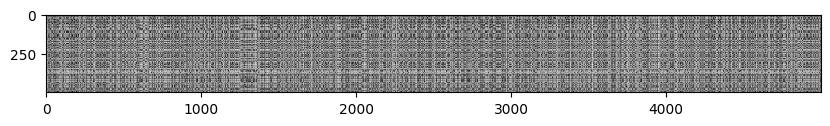

In [106]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

In [107]:
# TODO : Now implement the function predict_labels from the KNN class above and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (int(num_correct), num_test, accuracy))

Got 407 / 500 correct => accuracy: 0.814000


In [108]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (int(num_correct), num_test, accuracy))

Got 409 / 500 correct => accuracy: 0.818000


In [109]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [110]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [111]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)


# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 10.627333 seconds
One loop version took 6.659783 seconds
No loop version took 0.064804 seconds
One loop version took 6.659783 seconds
No loop version took 0.064804 seconds


In [112]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50]

################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for k in k_choices:
    accuracies = []
    for fold in range(num_folds):
        # Construire train/val
        X_val = X_train_folds[fold]
        y_val = y_train_folds[fold]
        X_tr = np.concatenate([f for i, f in enumerate(X_train_folds) if i != fold])
        y_tr = np.concatenate([f for i, f in enumerate(y_train_folds) if i != fold])

        # Entraîner
        classifier = KNearestNeighbor()
        classifier.train(X_tr, y_tr)

        # Prédire
        y_pred = classifier.predict(X_val, k=k, num_loops=0)

        # Calculer accuracy
        acc = np.mean(y_pred == y_val)
        accuracies.append(acc)

    k_to_accuracies[k] = accuracies

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.795000
k = 1, accuracy = 0.792000
k = 1, accuracy = 0.807000
k = 1, accuracy = 0.802000
k = 1, accuracy = 0.819000
k = 3, accuracy = 0.806000
k = 3, accuracy = 0.807000
k = 3, accuracy = 0.801000
k = 3, accuracy = 0.811000
k = 3, accuracy = 0.821000
k = 5, accuracy = 0.813000
k = 5, accuracy = 0.802000
k = 5, accuracy = 0.792000
k = 5, accuracy = 0.822000
k = 5, accuracy = 0.833000
k = 8, accuracy = 0.813000
k = 8, accuracy = 0.799000
k = 8, accuracy = 0.791000
k = 8, accuracy = 0.818000
k = 8, accuracy = 0.829000
k = 10, accuracy = 0.813000
k = 10, accuracy = 0.803000
k = 10, accuracy = 0.785000
k = 10, accuracy = 0.805000
k = 10, accuracy = 0.830000
k = 12, accuracy = 0.811000
k = 12, accuracy = 0.807000
k = 12, accuracy = 0.788000
k = 12, accuracy = 0.801000
k = 12, accuracy = 0.827000
k = 15, accuracy = 0.798000
k = 15, accuracy = 0.803000
k = 15, accuracy = 0.784000
k = 15, accuracy = 0.794000
k = 15, accuracy = 0.830000
k = 20, accuracy = 0.799000
k = 20, accu

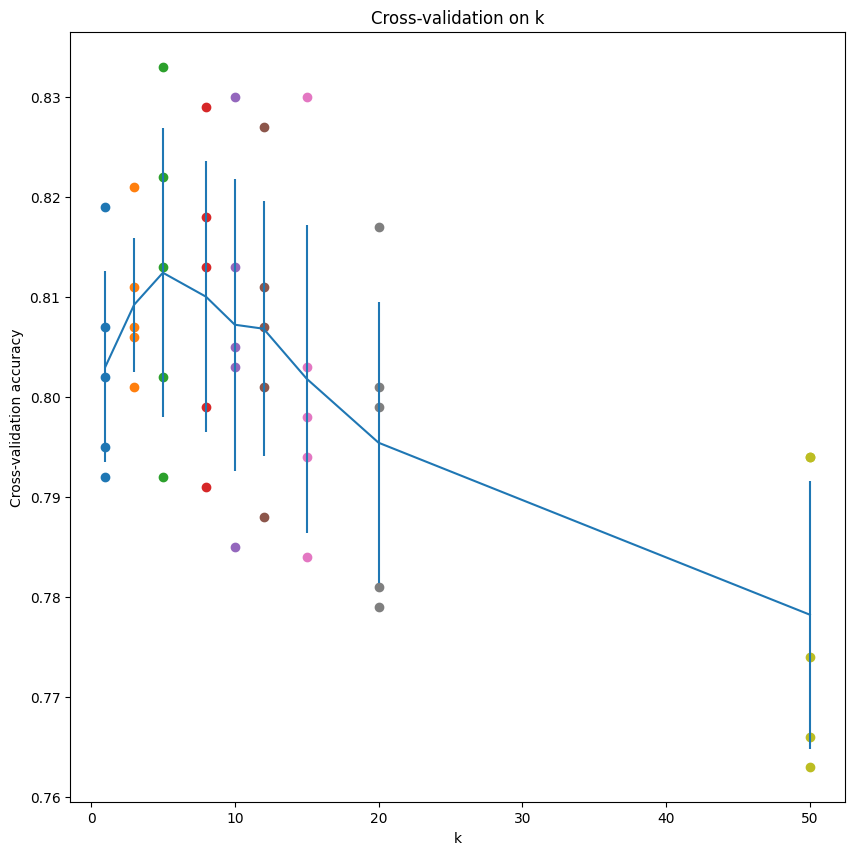

In [113]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [114]:
def get_best_k(k_to_accuracies):
    """
    Select the best value for k based on cross-validation results.
    If multiple k achieve the same mean accuracy, choose the smallest k.
    """
    best_k = None
    best_acc = -1.0

    for k, accs in k_to_accuracies.items():
        mean_acc = np.mean(accs)
        if mean_acc > best_acc or (mean_acc == best_acc and (best_k is None or k < best_k)):
            best_acc = mean_acc
            best_k = k

    return best_k


In [115]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 90% accuracy on the test data.
best_k = get_best_k(k_to_accuracies)

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (int(num_correct), num_test, accuracy))


Got 409 / 500 correct => accuracy: 0.818000
